In [20]:
import wandb
entity = "andresvanschel"
project = "eap"

In [26]:
# Initialize the API
api = wandb.Api()

# Retrieve the specific runs
run1 = api.run(f"{entity}/{project}/kyxryh60") # depth1, RD=1, PS=proof, threshold=0.08
run2 = api.run(f"{entity}/{project}/xsh8ugfv") # depth1, RD=1, PS=proof, threshold=0.02
run3 = api.run(f"{entity}/{project}/q6bwhxkm") # depth0, RD=0, PS=proof, threshold=0.02
run4 = api.run(f"{entity}/{project}/kgo44j99") # depth2, RD=2, PS=proof, threshold=0.02

# Store both runs in a list for later use
runs = [run3, run4]

In [22]:
import plotly.io as pio
import json

def plotly_from_wandb(run):
    # Get the file path from the run's summary
    plotly_file_path = run.summary["results"]["path"]

    # Download the file
    plotly_file = run.file(plotly_file_path).download(exist_ok=True)

    # Load the JSON content
    plotly_json = json.loads(plotly_file.read())
    
    # Create and display the figure
    fig = pio.from_json(json.dumps(plotly_json))
    fig.show()

    return plotly_json

In [23]:
import pandas as pd


def extract_and_sort_connections(plotly_json):
    # Extract text and y values from the plotly_json
    connections = plotly_json['data'][0]['text']
    importance = plotly_json['data'][0]['y']

    # Create a list of (connection, importance) tuples
    connection_importance = list(zip(connections, importance))

    # Sort by importance (y value) in descending order
    sorted_connections = sorted(connection_importance, key=lambda x: x[1], reverse=True)

    # # Display the top 20 most important connections
    # print("Top 20 most important connections:")
    # for i, (connection, importance) in enumerate(sorted_connections[:20]):
    #     print(f"{i+1}. {connection}: {importance:.4f}")

    # Create a DataFrame for better visualization if needed
    df_connections = pd.DataFrame({
        'Connection': [conn for conn, _ in sorted_connections],
        'Importance': [imp for _, imp in sorted_connections]
    })

    # Display summary statistics
    print("\nSummary Statistics:")
    print(f"Total connections: {len(sorted_connections)}")
    print(f"Maximum importance: {df_connections['Importance'].max():.4f}")
    print(f"Minimum importance: {df_connections['Importance'].min():.4f}")
    print(f"Average importance: {df_connections['Importance'].mean():.4f}")

    return df_connections, sorted_connections

In [24]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

def plot_results_distribution(df_connections, run, post_run_threshold=None):
    """
    Plot the distribution of connection importance values with KDE and statistical measures.
    
    Parameters:
    - df_connections: DataFrame containing connection importance values.
    - run: wandb run object for configuration and metadata.
    """
    # Extract importance values from df_connections
    importance_values = df_connections['Importance'].values

    plt.figure(figsize=(14, 7))

    # Get the threshold value from wandb run configuration
    threshold = run.config.get("threshold", None)
    num_examples = run.config.get("num_examples", None)
    model_depth = run.config.get("model_depth", None)
    reasoning_depth = run.config.get("proof_depth", None)
    proof_strategy = run.config.get("proof_strategy", None)

    # Calculate appropriate bin edges to ensure zero is a bin edge
    min_val = importance_values.min()
    max_val = importance_values.max()
    bin_count = 30

    if min_val < 0 and max_val > 0:
        # Ensure zero is a bin edge for clear separation of positive/negative values
        neg_bins = int(bin_count * abs(min_val) / (abs(min_val) + max_val))
        pos_bins = bin_count - neg_bins
        
        neg_edges = np.linspace(min_val, 0, neg_bins + 1)
        pos_edges = np.linspace(0, max_val, pos_bins + 1)
        bin_edges = np.unique(np.concatenate([neg_edges, pos_edges]))
    else:
        bin_edges = np.linspace(min_val, max_val, bin_count + 1)

    # Create histogram with KDE using the custom bins
    sns.histplot(importance_values, kde=True, bins=bin_edges, color='steelblue', alpha=0.7)

    # Add vertical lines for statistical measures
    plt.axvline(x=importance_values.mean(), color='r', linestyle='--', 
                label=f'Mean: {importance_values.mean():.4f}')
    plt.axvline(x=np.median(importance_values), color='g', linestyle='--', 
                label=f'Median: {importance_values.mean():.4f}')
    
    if post_run_threshold is not None:
        plt.axvline(x=post_run_threshold, color='orange', linestyle='--', 
                    label=f'Post-run Threshold: {post_run_threshold:.4f}')

    # Add threshold line if available
    if threshold is not None:
        plt.axvline(x=threshold, color='purple', linestyle='-', 
                    label=f'Threshold: {threshold:.4f}')
        
    # Calculate distribution metrics
    kurtosis = stats.kurtosis(importance_values)  # Measures peakedness/flatness
    std_dev = np.std(importance_values)          # Standard deviation
    q75, q25 = np.percentile(importance_values, [75, 25])
    iqr = q75 - q25                              # Interquartile range
    entropy = stats.entropy(np.histogram(importance_values, bins=20)[0])  # Distribution entropy

    # Highlight zero with a vertical line
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3, lw=1)

    # Add title and labels with more info
    plt.title(f'Distribution of Edge Importance Values\n(D{model_depth}, N={num_examples}, PS={proof_strategy}, RD={reasoning_depth}, Threshold={threshold})', fontsize=16, pad=10)
    plt.xlabel('Importance Value', fontsize=13)
    plt.ylabel('Frequency', fontsize=13)

    # Add information boxes for metrics
    # plt.text(0.98, 0.95, 
    #          f"Extremes:\nMax: {importance_values.max():.4f}\nMin: {importance_values.min():.4f}",
    #          transform=plt.gca().transAxes, ha='right', va='top',
    #          bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

    plt.text(0.02, 0.95, 
            f"Distribution metrics:\n" + 
            f"Kurtosis: {kurtosis:.4f} {'(more peaked)' if kurtosis > 0 else '(more flat)'}\n" +
            f"Std Dev: {std_dev:.4f}\n" +
            f"IQR: {iqr:.4f}\n" +
            f"Entropy: {entropy:.4f}\n" + 
            f"Extremes:\nMax: {importance_values.max():.4f}\n" + 
            f"Min: {importance_values.min():.4f}",
            transform=plt.gca().transAxes, ha='left', va='top',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

    # Print positive/negative counts below the plot
    pos_count = np.sum(importance_values > 0)
    neg_count = np.sum(importance_values < 0)
    zero_count = np.sum(importance_values == 0)
    plt.figtext(0.5, 0.01, 
                f"Positive values: {pos_count} ({pos_count/len(importance_values)*100:.1f}%) | " +
                f"Negative values: {neg_count} ({neg_count/len(importance_values)*100:.1f}%) | " +
                f"Zero values: {zero_count}", 
                ha='center', fontsize=11)

    # Add legend with better positioning and styling
    plt.legend(loc='upper right', framealpha=0.9, frameon=True)
    plt.grid(alpha=0.3, linestyle='--')
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Make room for the text at bottom
    plt.show()

    # Print additional statistics about the distribution
    print(f"Number of connections with importance > 0: {np.sum(importance_values > 0)} ({np.sum(importance_values > 0)/len(importance_values)*100:.2f}%)")
    print(f"Number of connections with importance < 0: {np.sum(importance_values < 0)} ({np.sum(importance_values < 0)/len(importance_values)*100:.2f}%)")
    print(f"Percentage of connections close to zero (|imp| < 0.1): {np.sum(np.abs(importance_values) < 0.1) / len(importance_values) * 100:.2f}%")
    print(f"\nDistribution metrics:")
    print(f"- Kurtosis: {kurtosis:.4f} ({'more peaked' if kurtosis > 0 else 'more flat'} than normal distribution)")
    print(f"- Standard deviation: {std_dev:.4f}")
    print(f"- Interquartile range: {iqr:.4f}")
    print(f"- Entropy: {entropy:.4f} (higher = more uniform/spread out)")

In [25]:
import pygraphviz as pgv
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import colorsys

def generate_graph(sorted_connections, top_n=None):
    """
    Generate a modern-looking graph using PyGraphviz with improved aesthetics.
    """
    if top_n is None:
        top_connections = sorted_connections
    else:
        # Use only top N most important connections
        top_connections = sorted_connections[:top_n]
    # Get min and max importance for normalization
    min_importance = min([imp for _, imp in top_connections])
    max_importance = max([imp for _, imp in top_connections])
    
    # Create a PyGraphviz AGraph
    G_pgv = pgv.AGraph(directed=True, strict=True)  # Set strict=True to merge edges

    # Set modern graph attributes
    G_pgv.graph_attr.update({
        'rankdir': 'LR',         # Left to right layout
        'splines': 'curved',     # Curved edges for modern look
        'overlap': 'scalexy',    # Better node positioning
        'sep': '+10',            # More space between nodes
        'nodesep': '0.6',        # Horizontal space between nodes
        'ranksep': '0.8',        # Vertical space between ranks
        'margin': '0.2',         # Margin
        'bgcolor': 'white',
        'fontname': 'Helvetica', # Modern font
        'dpi': '300'             # Higher resolution
    })

    # Dictionary to map node IDs to their labels
    node_id_to_label = {}
    # Dictionary to map labels to colors
    label_to_color = {}
    # Dictionary to track block numbers
    node_blocks = {}

    # First pass: Generate labels for all nodes
    for i, (connection, importance) in enumerate(top_connections):
        start_node, end_node = connection.split(" to ")
        
        # Process both nodes
        for node in [start_node, end_node]:
            if node not in node_id_to_label:
                # Extract block number
                parts = node.split('.')
                block_num = int(parts[1])
                node_blocks[node] = block_num
                
                # Create abbreviated label
                if 'hook_mlp' in node:
                    label = f"B{block_num}-MLP"
                elif 'attn.hook' in node:
                    if '[' in node:
                        head_num = node.split('[')[-1].split(',')[2].strip(']')
                        label = f"B{block_num}-H{head_num}"
                    else:
                        label = f"B{block_num}-Attn"
                else:
                    component = parts[2].split('[')[0]
                    label = f"B{block_num}-{component}"
                
                # Store mapping
                node_id_to_label[node] = label
                
                # Generate color based on block number (using HSV for better color distribution)
                hue = block_num / 15.0  # Assuming max 15 blocks, adjust as needed
                rgb = colorsys.hsv_to_rgb(hue, 0.7, 0.95)
                color = f"#{int(rgb[0]*255):02x}{int(rgb[1]*255):02x}{int(rgb[2]*255):02x}"
                label_to_color[label] = color

    # Second pass: Create the graph with merged nodes
    for i, (connection, importance) in enumerate(top_connections):
        start_node, end_node = connection.split(" to ")
        start_label = node_id_to_label[start_node]
        end_label = node_id_to_label[end_node]
        
        # Add nodes if they don't exist yet
        for node, label in [(start_node, start_label), (end_node, end_label)]:
            if not G_pgv.has_node(label):
                G_pgv.add_node(label, 
                            style='filled',
                            fillcolor=label_to_color[label],
                            fontcolor='black',
                            fontname='Helvetica-Bold',
                            shape='box',
                            width='0.6',
                            height='0.4',
                            penwidth=1.5,
                            margin='0.1',
                            rounded=True)  # Rounded corners for modern look
        
        # Normalize importance for edge width and color
        norm_importance = (importance - min_importance) / (max_importance - min_importance)
        edge_width = 1.5 + 4 * norm_importance
        
        # Modern color gradient for edges (from blue to red through purple)
        if importance > 1.5:  # High importance
            edge_color = f"#e74c3c"  # Red
        elif importance > 1.0:  # Medium importance
            edge_color = f"#9b59b6"  # Purple
        else:  # Lower importance
            edge_color = f"#3498db"  # Blue
        
        # Add edge with modern styling
        G_pgv.add_edge(start_label, end_label, 
                    label=f"{importance:.2f}",
                    penwidth=edge_width,
                    color=edge_color,
                    fontsize=9,
                    fontcolor='#2c3e50',
                    fontname='Helvetica',
                    arrowsize=0.8,
                    arrowhead='vee')  # Modern arrow style

    # Layout with "dot" for hierarchical directed graphs
    G_pgv.layout(prog='dot')

    # Set graph title
    G_pgv.graph_attr['label'] = 'Top Important Neural Network Component Connections'
    G_pgv.graph_attr['labelloc'] = 't'
    G_pgv.graph_attr['labelfontsize'] = '18'
    G_pgv.graph_attr['labelfontname'] = 'Helvetica-Bold'

    # Save the graph image
    output_file_pgv = 'important_connections_modern.png'
    G_pgv.draw(output_file_pgv, prog='dot')

    # Display the graph
    img = plt.imread(output_file_pgv)
    plt.figure(figsize=(20, 15))
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Create a more polished legend for block numbers
    plt.figure(figsize=(12, 3))
    legend_patches = []
    blocks_seen = sorted(set([node_blocks[node] for node in node_blocks]))

    # Group blocks into rows for better legend layout
    for block in blocks_seen:
        label = f'Block {block}'
        # Get label of a node with this block number
        sample_node = next(n for n in node_blocks if node_blocks[n] == block)
        sample_label = node_id_to_label[sample_node]
        color = label_to_color[sample_label]
        
        legend_patches.append(mpatches.Patch(color=color, 
                                            label=label,
                                            edgecolor='black',
                                            linewidth=0.5))

    plt.legend(handles=legend_patches, loc='center', title="Block Legend", 
            title_fontsize=14, fontsize=12, ncol=min(5, len(blocks_seen)),
            frameon=True, fancybox=True, shadow=True)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Print graph statistics with more detail
    print(f"Graph Statistics:")
    print(f"- Number of unique components: {G_pgv.number_of_nodes()}")
    print(f"- Number of connections: {G_pgv.number_of_edges()}")
    print(f"- Nodes merged: {len(node_id_to_label) - G_pgv.number_of_nodes()}")
    print(f"- Edges merged: {len(top_connections) - G_pgv.number_of_edges()}")
    print(f"- Top {top_n} connections visualized.")
    print(f"- Lowest importance value: {min_importance:.4f}")
    print(f"- Highest importance value: {max_importance:.4f}")


Processing run: q6bwhxkm



Summary Statistics:
Total connections: 439
Maximum importance: 4.5638
Minimum importance: -1.2266
Average importance: 0.1025


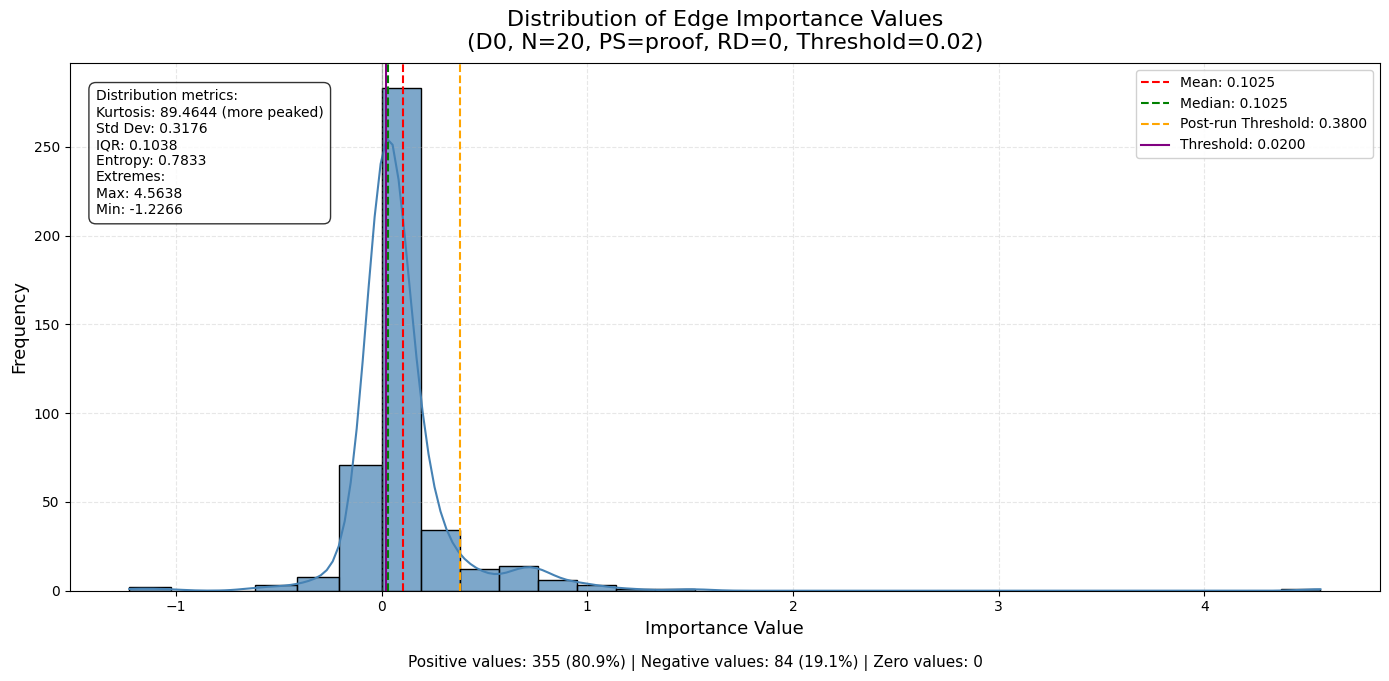

Number of connections with importance > 0: 355 (80.87%)
Number of connections with importance < 0: 84 (19.13%)
Percentage of connections close to zero (|imp| < 0.1): 68.56%

Distribution metrics:
- Kurtosis: 89.4644 (more peaked than normal distribution)
- Standard deviation: 0.3176
- Interquartile range: 0.1038
- Entropy: 0.7833 (higher = more uniform/spread out)

Processing run: kgo44j99



Summary Statistics:
Total connections: 619
Maximum importance: 5.2454
Minimum importance: -4.5174
Average importance: 0.1586


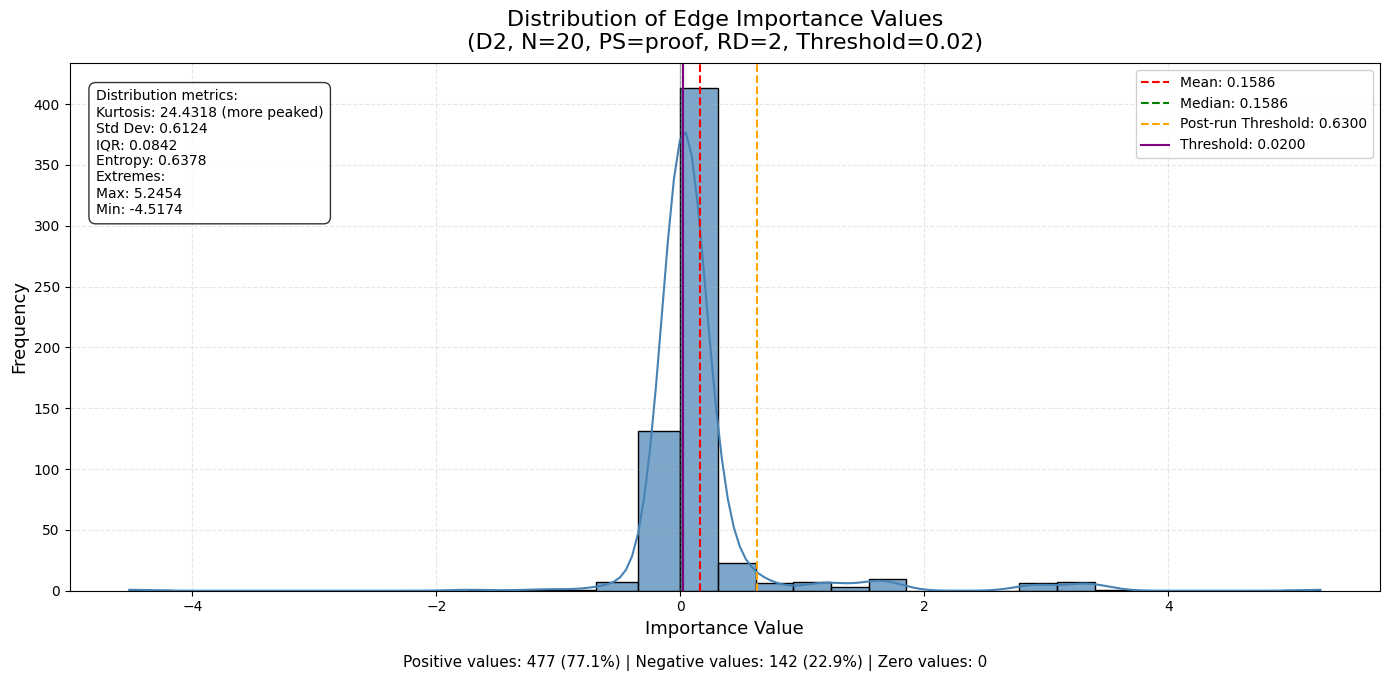

Number of connections with importance > 0: 477 (77.06%)
Number of connections with importance < 0: 142 (22.94%)
Percentage of connections close to zero (|imp| < 0.1): 73.34%

Distribution metrics:
- Kurtosis: 24.4318 (more peaked than normal distribution)
- Standard deviation: 0.6124
- Interquartile range: 0.0842
- Entropy: 0.6378 (higher = more uniform/spread out)


In [31]:
all_sorted_connections = []
post_run_thresholds = [0.38, 0.63]  # Example thresholds for post-run analysis
for i, run in enumerate(runs):
    print(f"\nProcessing run: {run.id}")
    # Extract and sort connections for each run
    plotly_json = plotly_from_wandb(run)
    df_connections, sorted_connections = extract_and_sort_connections(plotly_json)
    # Plot the distribution of connection importance values
    plot_results_distribution(df_connections, run, post_run_threshold=post_run_thresholds[i] if i < len(post_run_thresholds) else None)
    all_sorted_connections.append(sorted_connections)

c:\Users\andre\.conda\envs\data_prepping_and_analysis\lib\site-packages\pygraphviz\agraph.py:1407: RuntimeWarning:





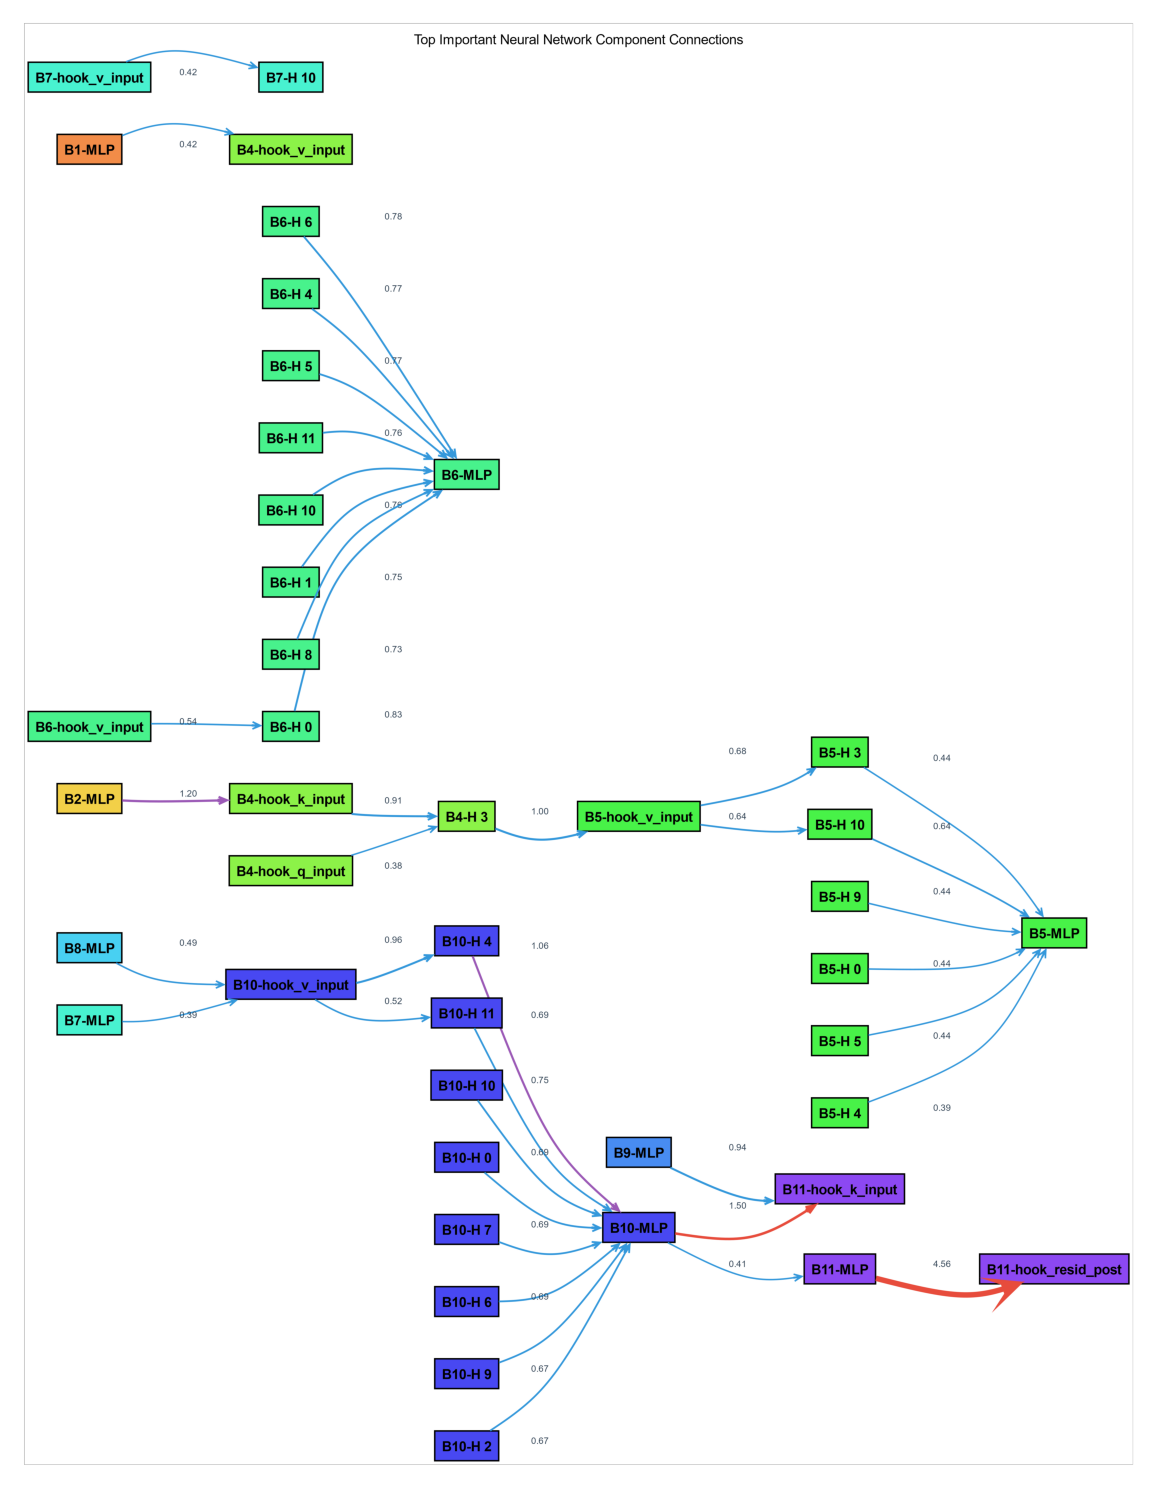

C:\Users\andre\AppData\Local\Temp\ipykernel_29436\961442130.py:156: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.



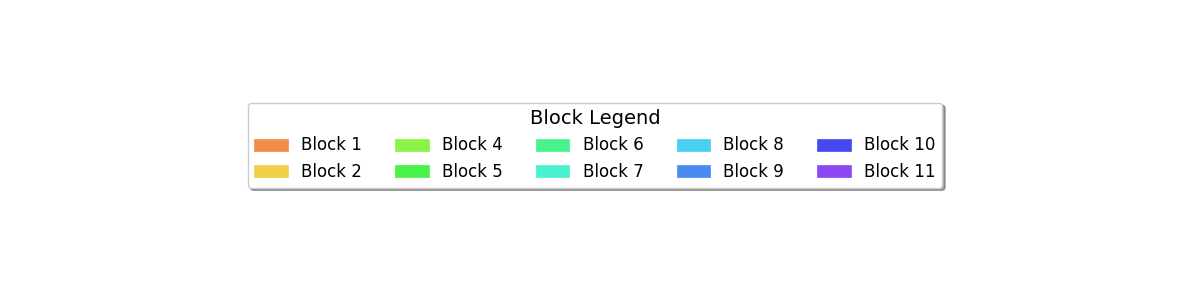

Graph Statistics:
- Number of unique components: 42
- Number of connections: 39
- Nodes merged: 12
- Edges merged: 0
- Top None connections visualized.
- Lowest importance value: 0.3801
- Highest importance value: 4.5638
Connections with importance < 0.38 are filtered out.


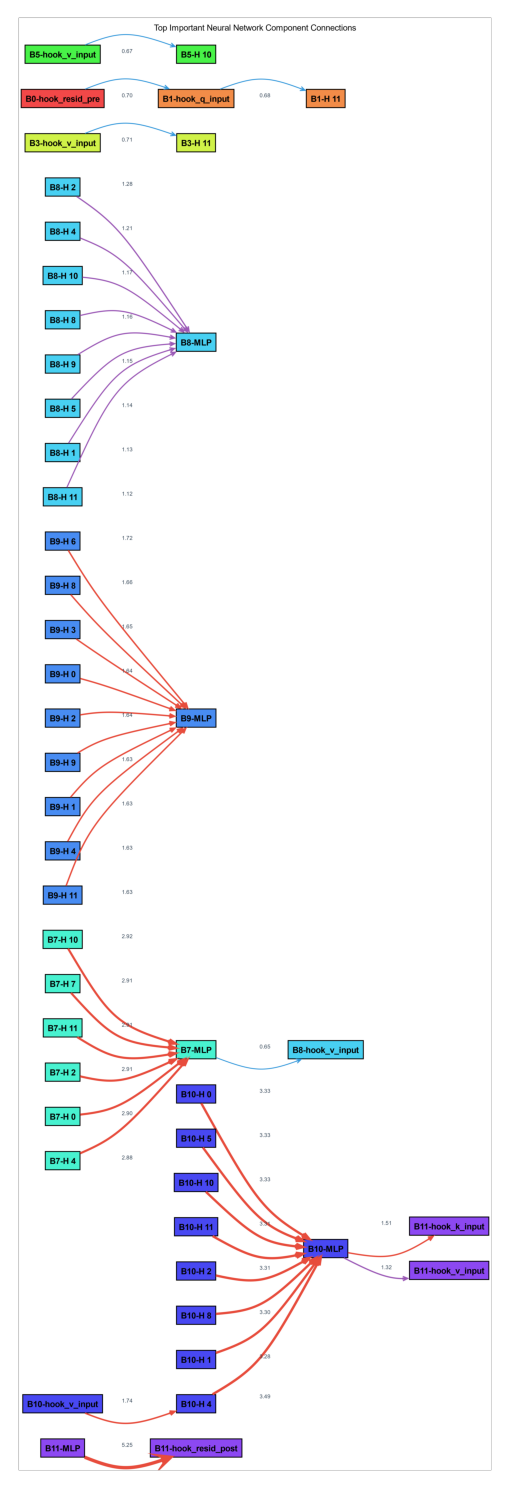

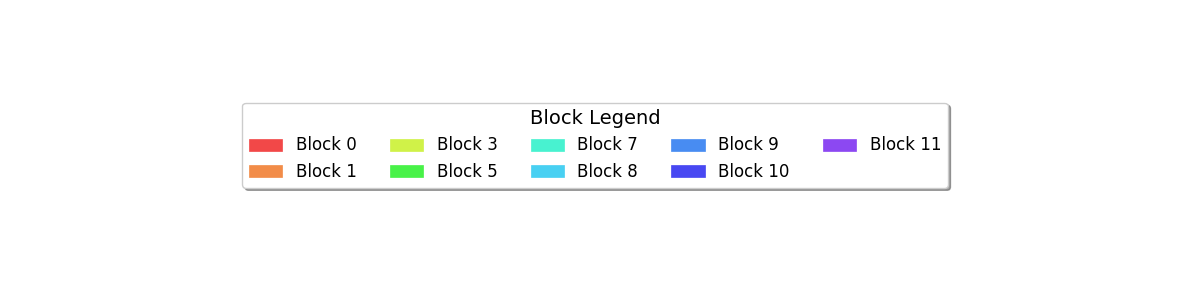

Graph Statistics:
- Number of unique components: 48
- Number of connections: 40
- Nodes merged: 3
- Edges merged: 0
- Top None connections visualized.
- Lowest importance value: 0.6482
- Highest importance value: 5.2454
Connections with importance < 0.63 are filtered out.


In [32]:
TOP_N = 20
CONNECTION_IMPORTANCE_THRESHOLDS = [0.38, 0.63]
for i, sorted_connections in enumerate(all_sorted_connections):
    if CONNECTION_IMPORTANCE_THRESHOLDS[i] is not None:
        sorted_connections = [conn for conn in sorted_connections if conn[1] > CONNECTION_IMPORTANCE_THRESHOLDS[i]]
        generate_graph(sorted_connections)
        print(f"Connections with importance < {CONNECTION_IMPORTANCE_THRESHOLDS[i]} are filtered out.")
    else:
        generate_graph(sorted_connections, top_n=TOP_N)
        print(f"Top {TOP_N} connections visualized.")
        

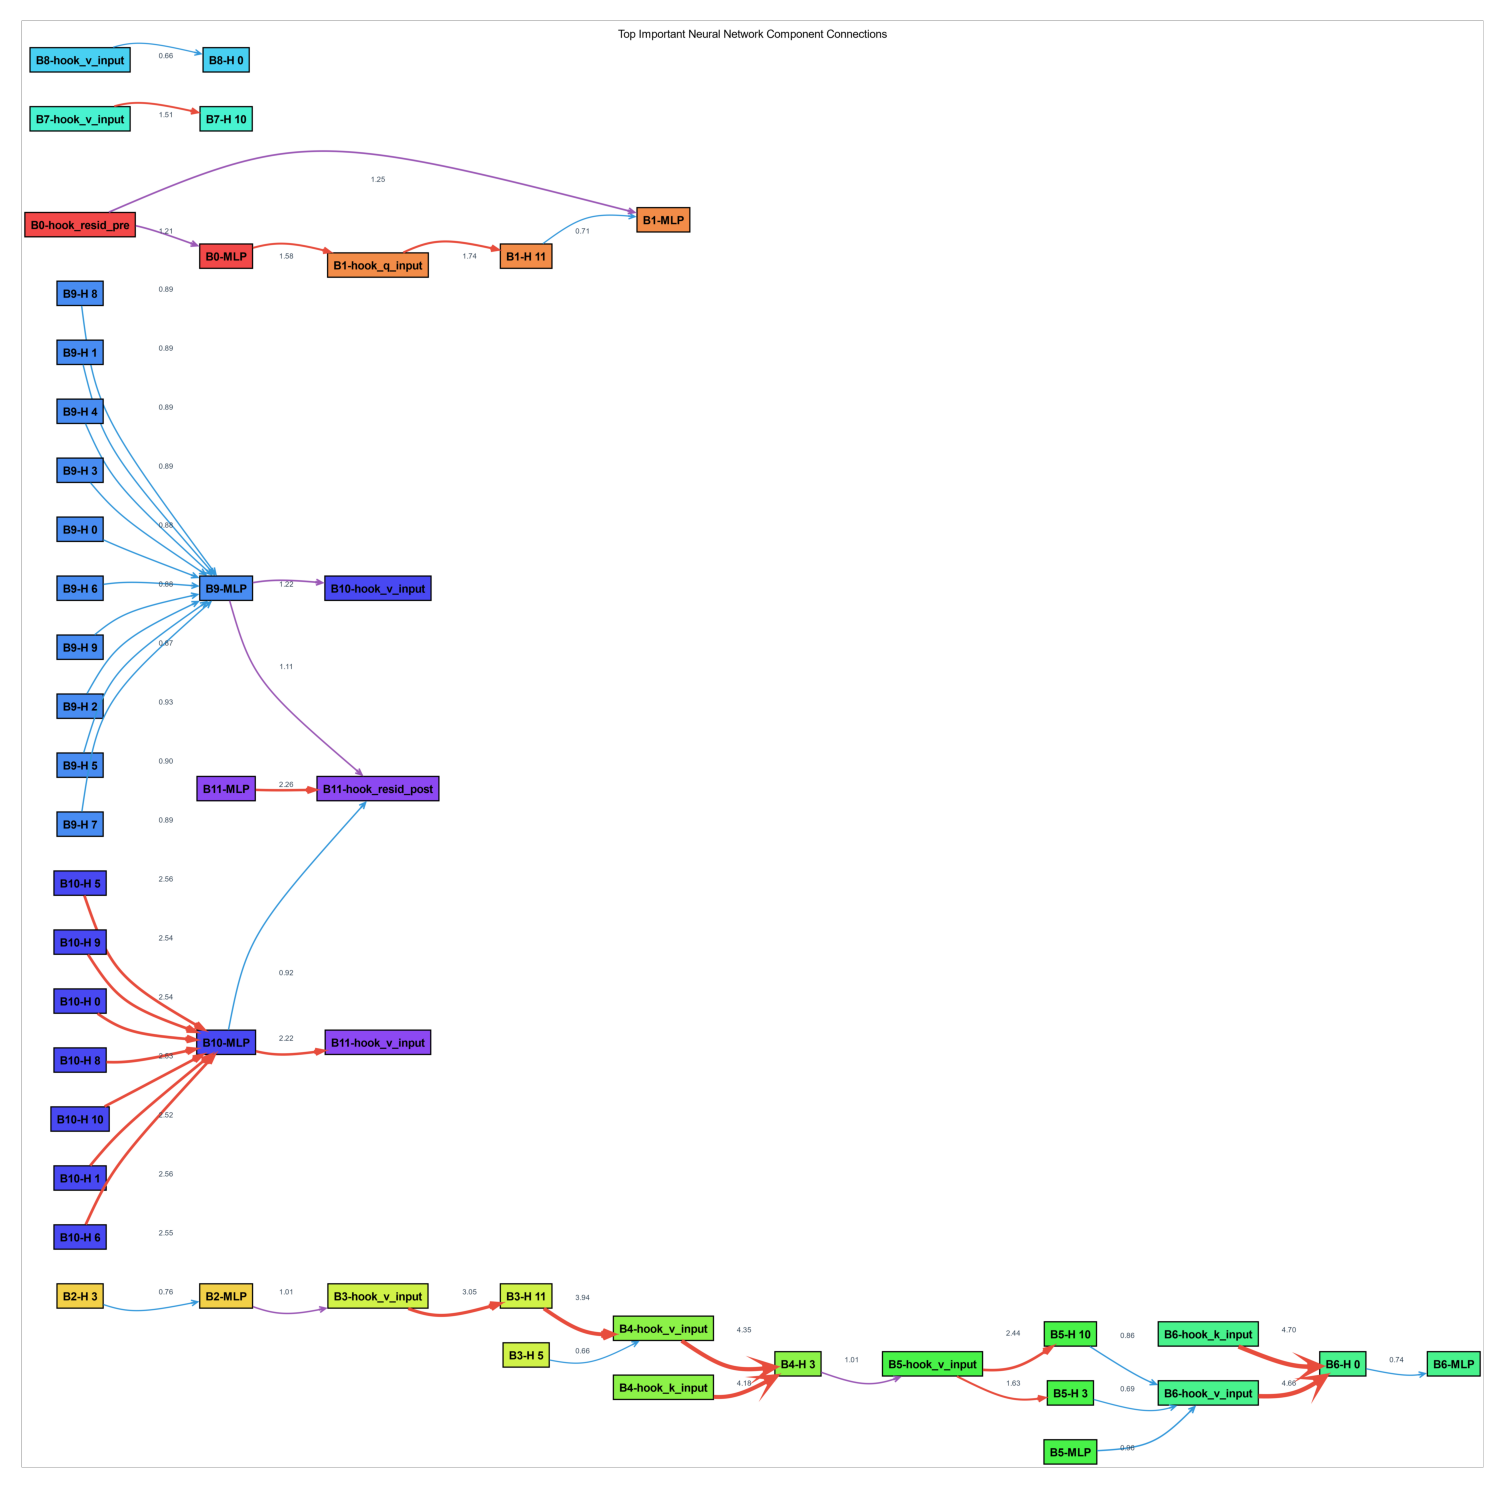

C:\Users\andre\AppData\Local\Temp\ipykernel_29436\961442130.py:156: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.



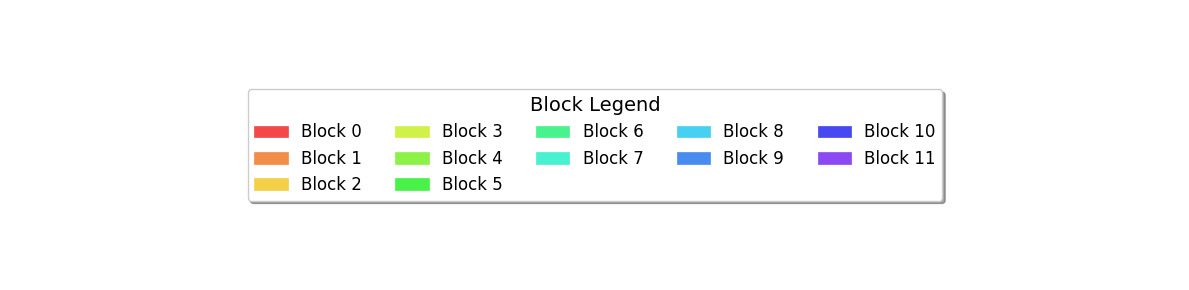

Graph Statistics:
- Number of unique components: 48
- Number of connections: 45
- Nodes merged: 13
- Edges merged: 1
- Top None connections visualized.
- Lowest importance value: 0.6573
- Highest importance value: 4.7033
Connections with importance < [0.08, 0.4] are filtered out.


In [19]:
TOP_N = 20
CONNECTION_IMPORTANCE_THRESHOLD = 0.65
sorted_connections = all_sorted_connections[1]
if CONNECTION_IMPORTANCE_THRESHOLD is not None:
    sorted_connections = [conn for conn in sorted_connections if conn[1] > CONNECTION_IMPORTANCE_THRESHOLD]
    generate_graph(sorted_connections)
    print(f"Connections with importance < {CONNECTION_IMPORTANCE_THRESHOLDS} are filtered out.")
else:
    generate_graph(sorted_connections, top_n=TOP_N)
    print(f"Top {TOP_N} connections visualized.")
        